In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from models.predictors import HandWinPredictor

In [2]:
df = pd.read_csv("data/hole_card_data.csv")

In [3]:
class PokerDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        attributes = [row['suited'], row['connectedness'], row['pair']]
        hand_idx = row['hand_idx']
        win_percentage = row['river_win_rate']
        return (
            torch.tensor(hand_idx, dtype=torch.long),
            torch.tensor(attributes, dtype=torch.float32), 
            torch.tensor(win_percentage, dtype=torch.float32)
            )

In [4]:
dataset = PokerDataset(df)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [5]:
embedding_dim = 8
model = HandWinPredictor(hand_embedding_dim=embedding_dim, hidden_dims=[64, 32, 16])
optimizer = torch.optim.Adam(params=model.parameters(), lr=.001)
loss_fn = nn.MSELoss()
epochs = 200

In [6]:
train_losses = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        hole_card_idx, hole_card_attributes, targets = batch
        optimizer.zero_grad()
        outputs = model(hole_card_idx, hole_card_attributes)
        loss = loss_fn(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
            
        total_loss += loss.item()
    avg_loss = total_loss/len(dataloader)
    train_losses.append(avg_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {round(avg_loss, 5)}")
    

Epoch 10/200, Loss: 0.0081
Epoch 20/200, Loss: 0.00519
Epoch 30/200, Loss: 0.00527
Epoch 40/200, Loss: 0.00319
Epoch 50/200, Loss: 0.00344
Epoch 60/200, Loss: 0.00427
Epoch 70/200, Loss: 0.0035
Epoch 80/200, Loss: 0.00231
Epoch 90/200, Loss: 0.00212
Epoch 100/200, Loss: 0.00253
Epoch 110/200, Loss: 0.00245
Epoch 120/200, Loss: 0.00257
Epoch 130/200, Loss: 0.00219
Epoch 140/200, Loss: 0.00222
Epoch 150/200, Loss: 0.00318
Epoch 160/200, Loss: 0.0018
Epoch 170/200, Loss: 0.0019
Epoch 180/200, Loss: 0.00166
Epoch 190/200, Loss: 0.00143
Epoch 200/200, Loss: 0.00136


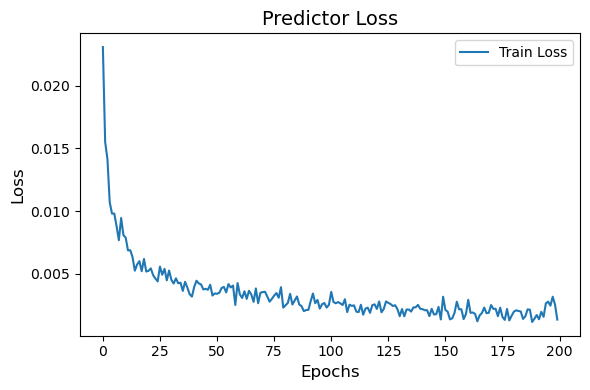

In [7]:
plt.figure(figsize=(6, 4))
sns.lineplot(x=list(range(epochs)), y=train_losses, label="Train Loss")
plt.title("Predictor Loss", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=10) 
plt.tight_layout()
plt.show()

In [9]:
torch.save(model.encoder.state_dict(), 'hand_embedding_weights/embeddings_model1.pt')